In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName('ddam_project')
         .config('spark.some.config.option','some-value')
         .getOrCreate()
         )

In [3]:
# read file from hdfs and infer schema
df_raw = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/Hotel_Reviews.csv", header = True, inferSchema = True)
df_cleaned = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_cleaned.csv", header = True, inferSchema = True)
#df_cleaned.printSchema()

In [4]:
raw_count = df_raw.count()

In [5]:
cleaned_count = df_cleaned.count()

In [6]:
raw_count

515738

In [7]:
1-cleaned_count/raw_count

0.020841977903509168

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
vader = SentimentIntensityAnalyzer()

In [9]:
def errors(rdd, ix, iy):
    ''' 
    rdd= rdd composed by lists/tuples 
    ix: index of the first variable
    iy: index of the second variable
    return: dictionary with 
    {'rmse': root mean squared error
     'mae' : mean absolute error
    }
    
    '''
    # acc = ('counts', sum of abs errors', 'sum of squared errors')
    acc = (0, 0, 0)
    def mergeValue(acc, value):
        return (acc[0] + 1, acc[1] + value,  acc[2] + value**2)
    
    def mergeAccum(acc1,acc2):
        return (acc1[0] + acc2[0], acc1[1] + acc2[1], acc1[2]+acc2[2])
    
    acc = (rdd.map(lambda x: ( np.abs(x[ix] - x[iy]) ))
       .aggregate(acc, mergeValue, mergeAccum)
      )
    
    return {'rmse':np.sqrt(acc[2]/acc[0]) , 'mae': acc[1]/acc[0] }
    
    

In [10]:
def apply_vader(x):
    
    # scaling score in range [2,8]
    score = (((vader.polarity_scores(x["Review"])['compound']  ) +1)*4+2 )
        
    return (x['Reviewer_Nationality'], x['Reviewer_Score'], score)

In [11]:
def apply_vader_bias(x, bias= 0.0):
    
    score = ((vader.polarity_scores(x["Review"])['compound']+1 )*5 ) + bias
        
    # handling scores 'overflow'
    if score > 10:
        score = 10
    elif score < 0:
        score = 0
        
    return (x['Reviewer_Nationality'], x['Reviewer_Score'], score)

In [14]:
df_cleaned.select('Reviewer_Score').rdd.min()

Row(Reviewer_Score=2.5)

In [15]:
rdd_scores = df_cleaned.rdd.map(apply_vader)

In [16]:
vader_errors = errors(rdd_scores, 1, 2)
vader_errors

{'mae': 1.3675094712954294, 'rmse': 1.8599262218312351}

In [17]:
df_scores = rdd_scores.toDF(['Reviewer_Nationality', 'Reviewer_Score','Vader_Score'])

In [18]:
df_scores.approxQuantile("Vader_Score", [0.5], 0.0)[0]

8.8252

# Distribution plots

In [19]:
###########################################################
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y label
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

###########################################################


In [20]:
df_sample = df_scores.sample(False, 0.10).toPandas()


In [21]:
df_sample.describe()

,Reviewer_Score,Vader_Score
count,50172.000000,50172.000000
mean,8.406372,8.028945
std,1.620239,1.952814
min,2.500000,2.024000
25%,7.500000,6.711600
50%,8.800000,8.833200
75%,9.600000,9.590800
max,10.000000,9.996800


In [22]:
df_sample['bias'] = df_sample['Vader_Score'] - df_sample['Reviewer_Score']

In [23]:
df_sample.describe()

,Reviewer_Score,Vader_Score,bias
count,50172.000000,50172.000000,50172.000000
mean,8.406372,8.028945,-0.377427
std,1.620239,1.952814,1.812667
min,2.500000,2.024000,-7.608800
25%,7.500000,6.711600,-1.312400
50%,8.800000,8.833200,-0.207600
75%,9.600000,9.590800,0.663200
max,10.000000,9.996800,7.356400


In [24]:
df_sample.groupby(np.round(df_sample.Reviewer_Score,0)).mean().bias

Reviewer_Score
2.0     1.999645
3.0     1.333672
4.0     1.139208
5.0     0.780139
6.0     0.574375
7.0     0.209296
8.0    -0.032486
9.0    -0.540449
10.0   -1.054171
Name: bias, dtype: float64

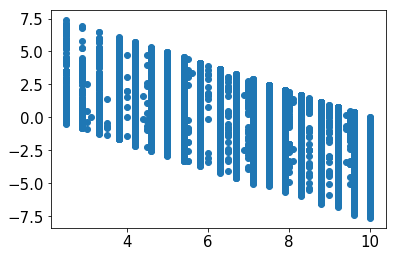

In [25]:
plt.scatter(df_sample.Reviewer_Score, df_sample.bias)

In [26]:
df_sample.describe()

,Reviewer_Score,Vader_Score,bias
count,50172.000000,50172.000000,50172.000000
mean,8.406372,8.028945,-0.377427
std,1.620239,1.952814,1.812667
min,2.500000,2.024000,-7.608800
25%,7.500000,6.711600,-1.312400
50%,8.800000,8.833200,-0.207600
75%,9.600000,9.590800,0.663200
max,10.000000,9.996800,7.356400


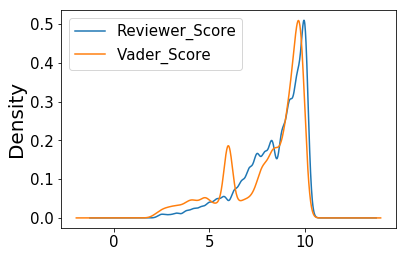

In [27]:
#fig, ax = plt.subplots(figsize=(10, 6))
df_sample[['Reviewer_Score','Vader_Score']].plot.kde()

In [28]:
import seaborn as sns

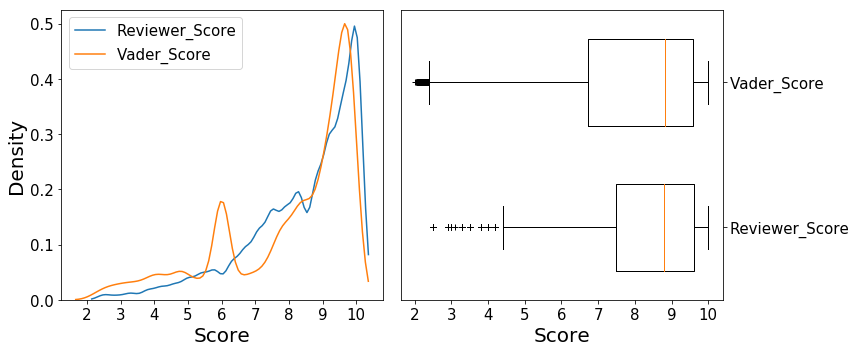

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
grid = plt.GridSpec(1, 4, wspace=0.5, hspace=0.7)

ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=2)
sns.kdeplot( df_sample['Reviewer_Score'].values, bw =0.12, label = 'Reviewer_Score')
sns.kdeplot( df_sample['Vader_Score'].values, bw =0.12, label = 'Vader_Score')
plt.ylabel('Density')
plt.xlabel('Score')
plt.xticks(np.arange(2,11,1))

ax2 = plt.subplot2grid((1, 4), (0, 2), colspan=2)

#sns.boxplot( y=df_sample["Reviewer_Score"], x=df_sample["Vader_Score"] )


bp = plt.boxplot(df_sample[['Reviewer_Score','Vader_Score']].values, vert =False, widths = 0.6)
ax2.set_yticklabels(['Reviewer_Score', 'Vader_Score'], rotation = 0)
ax2.yaxis.tick_right()
ax2.set_xticks(np.arange(2,11,1))
ax2.set_xlabel('Score')
#plt.axhline(tot_median, color = 'red', linestyle = "--")
#plt.axhline(tot_avg, color = 'green', linestyle = ":")

plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
#ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
#               alpha=0.5)
plt.tight_layout()
plt.savefig('images/vader_evaluation.pdf')

# Nationality bias correction

In [30]:
df_bias_median = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_bias_median.csv", header = True, inferSchema = True)
df_bias_median = df_bias_median.select("Reviewer_Nationality", "Bias_median", "N").orderBy('Bias_median')
df_bias_median.show(100)

+--------------------+-------------------+------+
|Reviewer_Nationality|        Bias_median|     N|
+--------------------+-------------------+------+
|               Macau|-0.9000000000000004|   105|
|          Azerbaijan|-0.9000000000000004|   262|
|          Bangladesh|-0.9000000000000004|   140|
|            Pakistan|-0.9000000000000004|   874|
|                Iran|-0.9000000000000004|  1033|
|               Ghana|               -0.5|   137|
|           Hong Kong|               -0.5|  2967|
|           Singapore|               -0.5|  3047|
|                Oman|               -0.5|  1295|
|                null|               -0.5|   511|
|           Indonesia|               -0.5|  1493|
|        Saudi Arabia|               -0.5|  8413|
|         Switzerland|               -0.5|  8555|
|             Belgium|               -0.5|  5918|
|United Arab Emirates|               -0.5|  9779|
|               Qatar|               -0.5|  2583|
|               Kenya|               -0.5|   258|


In [31]:
df_joined_median = df_cleaned.join(df_bias_median, 'Reviewer_Nationality', 'left')

In [32]:
try:
    df_joined_median.createTempView('bias_median')
except:
    spark.catalog.dropTempView('bias_median')
    df_joined_median.createTempView('bias_median')

In [33]:
def apply_vader_bias_nationality(x):
  
    if x["Bias_median"] == None:
        score = (((vader.polarity_scores(x["Review"])['compound']  ) +1)*4+2 ) + 0
    else:
        score = (((vader.polarity_scores(x["Review"])['compound']  ) +1)*4+2 ) + x["Bias_median"]
        
    # handling scores 'overflow'
    if score > 10:
        score = 10
    elif score < 0:
        score = 0
        
    return (x['Reviewer_Nationality'], x['Reviewer_Score'], score)

In [34]:
rdd_bias_median = (df_joined_median.rdd
              #.filter(lambda row: row['Review'] is not None) 
              .map(apply_vader_bias_nationality)
             )
rdd_bias_median.take(20)

[('Canada', 8.8, 9.746799999999999),
 ('United Kingdom', 9.2, 9.273599999999998),
 ('United Kingdom', 8.8, 10),
 ('United Kingdom', 9.6, 6.399999999999999),
 ('United Kingdom', 9.2, 6.399999999999999),
 ('Australia', 10.0, 10),
 ('United Kingdom', 5.0, 5.1747999999999985),
 ('United Kingdom', 9.2, 10),
 ('United Kingdom', 9.6, 10),
 ('Brazil', 9.2, 8.97),
 ('Netherlands', 8.3, 9.299199999999999),
 ('United Kingdom', 9.6, 9.870399999999998),
 ('United Kingdom', 9.2, 8.085999999999999),
 ('India', 9.6, 5.5),
 ('United Kingdom', 7.1, 7.012399999999999),
 ('Italy', 7.1, 4.6772),
 ('United Kingdom', 9.6, 9.689999999999998),
 ('Sweden', 8.3, 8.8012),
 ('Hong Kong', 7.5, 8.581199999999999),
 ('United Kingdom', 8.3, 4.170399999999999)]

In [35]:
vader_errors_bias_median = errors(rdd_bias_median, 1, 2)

In [36]:
vader_errors_bias_median

{'mae': 1.3559467932964713, 'rmse': 1.8537900481717495}

In [37]:
vader_errors

{'mae': 1.3675094712954294, 'rmse': 1.8599262218312351}

In [38]:

pd.DataFrame([vader_errors,vader_errors_bias_median], index = ['vader', 'vader_nationality'])

,mae,rmse
vader,1.367509,1.859926
vader_nationality,1.355947,1.853790


In [39]:
with open('images/vader_evaluation.tex', 'w') as f:
    f.write(
        pd.DataFrame([vader_errors,vader_errors_bias_median], index = ['vader', 'vader_nationality']).to_latex()
    )

In [ ]:
# errore per country

In [42]:
errors(rdd_scores.filter(lambda x: x[0]=="United States of America"), 1,2 )

{'mae': 1.2512977097486182, 'rmse': 1.779153976198363}

In [41]:
errors(rdd_bias_median.filter(lambda x: x[0]=="United States of America"), 1,2 )

{'mae': 1.168901963482099, 'rmse': 1.697236683916017}